# Neural Network Training Template (PyTorch)

This notebook provides a template for training a neural network using PyTorch.

---

## 1. Dataset Loading and Preparation

In [61]:
import os
import re
import imutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
from PIL import Image, ImageOps
import pytesseract
import cv2
import io

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
curr_dir = os.getcwd()


In [2]:
hugging_face_ds = load_dataset("George511242/Facebook_harmeme_dataset")

In [3]:
# Load train and test sets to pandas
hugging_face_train_df = hugging_face_ds["train"].to_pandas()
hugging_face_test_df = hugging_face_ds["test"].to_pandas()

In [4]:
# Convert ID's to numeric
hugging_face_train_df["id"] = pd.to_numeric(hugging_face_train_df["id"])
hugging_face_test_df["id"] = pd.to_numeric(hugging_face_test_df["id"])

In [9]:
# Build standard columns for textual prompt and a boolean label weather the content is harmful
def build_textual_prompt_object(df):
    if 'conversations' in df.columns:
        all_conversations = list(df['conversations'])
        df['textual_prompt'] = [item[0]['value'] for item in all_conversations]
        df['is_harmful'] = [item[1]['value'] for item in all_conversations]
        df['is_harmful'] = df['is_harmful'].eq('Yes').mul(True)
        
build_textual_prompt_object(hugging_face_train_df)
build_textual_prompt_object(hugging_face_test_df)

In [12]:
def get_image_text(df):
    list_image_texts = []
    if 'image_text' in df.columns:
        return df['image_text']
    
    for prompt in df['textual_prompt']:
        match = re.search(r'The text in the meme is: (.*?)\.\n<image>\n', prompt)
        if match:
            list_image_texts.append(match.group(1))
        else:
            list_image_texts.append('')
    return list_image_texts

hugging_face_train_df['image_text'] = get_image_text(hugging_face_train_df)
hugging_face_test_df['image_text'] = get_image_text(hugging_face_test_df)

In [13]:
# Save all images bytes in files and save in the dataframe the image path 
os.makedirs('images', exist_ok=True)

def build_images_column(df):
    if 'image_path' in df.columns:
        return df['image_path']
        
    list_paths = []
    for image in df['image']:
        save_path = f'images/{image['path']}'
        list_paths.append(save_path)
        
        if not os.path.exists(save_path):
            with open(save_path, 'wb') as f:
                f.write(image['bytes'])
    return list_paths

hugging_face_train_df['image_path'] = build_images_column(hugging_face_train_df)
hugging_face_test_df['image_path'] = build_images_column(hugging_face_test_df)

In [14]:
# Remove not used columns after being proccesed
hugging_face_train_df = hugging_face_train_df.drop(columns=['image', 'conversations'], errors='ignore')
hugging_face_test_df = hugging_face_test_df.drop(columns=['image', 'conversations'], errors='ignore')

In [17]:
hugging_face_train_df.loc[hugging_face_train_df.id == 1243].image_text.values[0]

'when your human says "who\' s a good girl?" and you already know it\'s you'

In [44]:
# Set the desired image size for resizing
img_size = 64

# Define the image transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

print(f"image transform: {transform}")

image transform: Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [48]:
def build_image_tensors(df):
    if 'image_tensor' in df.columns:
        return df['image_tensor']
    
    image_tensors = []
    for i, path in enumerate(df['image_path']):
        #print(path)
        #break
        img = Image.open(path).convert("RGB") # Ensure consistent channel format
        tensor_img = transform(img)
        image_tensors.append(tensor_img)

        if ((i+1) % 100 == 0):
            print(f"Complete {i+1} of {len(df['image_path'])} images")
    return image_tensors

hugging_face_train_df['image_tensor'] = build_image_tensors(hugging_face_train_df)
hugging_face_test_df['image_tensor'] = build_image_tensors(hugging_face_test_df)

Complete 100 of 8500 images
Complete 200 of 8500 images
Complete 300 of 8500 images
Complete 400 of 8500 images
Complete 500 of 8500 images
Complete 600 of 8500 images
Complete 700 of 8500 images
Complete 800 of 8500 images
Complete 900 of 8500 images
Complete 1000 of 8500 images
Complete 1100 of 8500 images
Complete 1200 of 8500 images
Complete 1300 of 8500 images
Complete 1400 of 8500 images
Complete 1500 of 8500 images
Complete 1600 of 8500 images
Complete 1700 of 8500 images
Complete 1800 of 8500 images
Complete 1900 of 8500 images
Complete 2000 of 8500 images
Complete 2100 of 8500 images
Complete 2200 of 8500 images
Complete 2300 of 8500 images
Complete 2400 of 8500 images
Complete 2500 of 8500 images
Complete 2600 of 8500 images
Complete 2700 of 8500 images
Complete 2800 of 8500 images
Complete 2900 of 8500 images
Complete 3000 of 8500 images
Complete 3100 of 8500 images
Complete 3200 of 8500 images
Complete 3300 of 8500 images
Complete 3400 of 8500 images
Complete 3500 of 8500 i

In [57]:
hugging_face_train_df.head()

,id,textual_prompt,is_harmful,image_text,image_path,image_tensor
0,1235,A direct or indirect attack on people based on...,True,when you're feeling horny asf but your habibi ...,images/01235.png,"[[[tensor(0.6863), tensor(0.7569), tensor(0.76..."
1,1236,A direct or indirect attack on people based on...,False,meanwhile at the isis strip club,images/01236.png,"[[[tensor(0.9608), tensor(0.9804), tensor(0.98..."
2,1243,A direct or indirect attack on people based on...,False,"when your human says ""who' s a good girl?"" and...",images/01243.png,"[[[tensor(0.3569), tensor(0.3922), tensor(0.43..."
3,1245,A direct or indirect attack on people based on...,True,and that was the last nativity play my son was...,images/01245.png,"[[[tensor(0.0235), tensor(0.0196), tensor(0.08..."
4,1247,A direct or indirect attack on people based on...,True,you can't be racist if there is no other race,images/01247.png,"[[[tensor(0.0863), tensor(0.0980), tensor(0.09..."


In [58]:
hugging_face_test_df.head()

,id,textual_prompt,is_harmful,image_text,image_path,image_tensor
0,1268,A direct or indirect attack on people based on...,False,father and daughter bonding time is the best l...,images/01268.png,"[[[tensor(0.5922), tensor(0.5922), tensor(0.60..."
1,1456,A direct or indirect attack on people based on...,True,they see them rollin..... they hating..,images/01456.png,"[[[tensor(0.6235), tensor(0.1961), tensor(0.29..."
2,1726,A direct or indirect attack on people based on...,True,a real man loads the dishwasher every night,images/01726.png,"[[[tensor(0.3569), tensor(0.5255), tensor(0.49..."
3,1742,A direct or indirect attack on people based on...,False,in just one hour from now i'll only have 4 hou...,images/01742.png,"[[[tensor(0.6588), tensor(0.6863), tensor(0.78..."
4,1765,A direct or indirect attack on people based on...,True,"after a girl dies, what organ in her body stay...",images/01765.png,"[[[tensor(0.0784), tensor(0.0863), tensor(0.08..."


In [87]:
def plot_class_distribution(df, color, dataset_type):
    fig = plt.figure(figsize=(5, 5))
    is_harmful = df['is_harmful'].astype(int)
    
    plt.hist(is_harmful, bins=2, align='left', edgecolor='black', color=color)
    plt.xticks([0, 0.5], ['False', 'True'])
    plt.xlabel("Is Harmful ?")
    plt.ylabel("Count")
    plt.title(f"{dataset_type} dataset")

    plt.show()

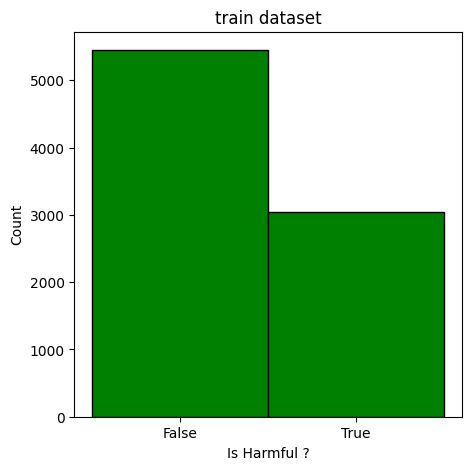

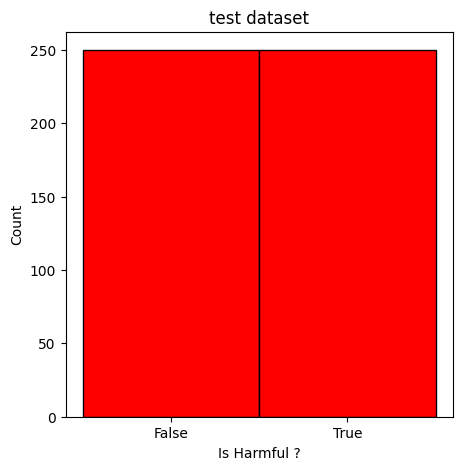

In [88]:
plot_class_distribution(hugging_face_train_df, 'green', 'train')
plot_class_distribution(hugging_face_test_df, 'red', 'test')

## 2. Neural Network Class (PyTorch)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = SimpleNN()

## 3. Training and Evaluation

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

## 4. Results Visualization

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()